# Afriat

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

In [3]:
torch.cuda.is_available()

True

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|status_control",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|zone",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|time_cat",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|mouse",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [7]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = [False, False],
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2,
                method = "mse_z", 
                latent_group = "unreserved",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1, 
                method = "mse_z", 
                latent_group = "unreserved",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [8]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    encode_covariates=False,
    beta_kl_weight = 0.5,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=['status_control', 'time_cat'],
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['zone', 'status_control', 'time_cat', 'mouse']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_v3_1_encode"
)

vae.save(
    dir_path,
    overwrite=True,
)

CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8907, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/tmp/ipykernel_1691717/1884487943.py:51: UserWarning: `(None, ['status_control', 'time_cat'])` is defined as `batch_key` or `categorical_covariate`, it will be given to both encoder and decoder. Make sure this does not contain information of any of your disentenglement targets. For example, if `donor_id` is chosen as a batch key, do not disentengle donor level information such as `sex` or `age`. The decoder should not use the disentengled latent spaces, simply ignores, if

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_figures
ID: y7aa6z6u
Name: crisp-durian-64
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_figures/runs/y7aa6z6u
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240502_092856-y7aa6z6u/files



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-d7a14d27-a4ce-50f4-ac0d-9574c956ed5a,MIG-c1e0b253-b0df-5a6c-88e9-2330111f3783]
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. P

Epoch 1/600:   0%|                                                                                                                                                                                                                | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4465,10778
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1119,2691
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 600/600: 100%|███████| 600/600 [32:13<00:00,  3.00s/it, v_num=6u_1, total_loss_train=2.89e+3, kl_local_train=56.4, metric_mi|status_control_train=0.0227, metric_mi|zone_train=0.262, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0554]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|███████| 600/600 [32:14<00:00,  3.22s/it, v_num=6u_1, total_loss_train=2.89e+3, kl_local_train=56.4, metric_mi|status_control_train=0.0227, metric_mi|zone_train=0.262, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0554]
W&B logger finalized successfully: 
Exit Code: 0



In [9]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1691717/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [10]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9995733079711416,
 ('train', 'total'): 0.9997047908846981}

/tmp/ipykernel_1691717/1690008648.py:1: UserWarning: Validation is not calculated during training for `metric_mi|status_control`.
  vae.plot_training_history(
/tmp/ipykernel_1691717/1690008648.py:1: UserWarning: Validation is not calculated during training for `metric_mi|zone`.
  vae.plot_training_history(
/tmp/ipykernel_1691717/1690008648.py:1: UserWarning: Validation is not calculated during training for `metric_mi|time_cat`.
  vae.plot_training_history(
/tmp/ipykernel_1691717/1690008648.py:1: UserWarning: Validation is not calculated during training for `metric_mi|mouse`.
  vae.plot_training_history(


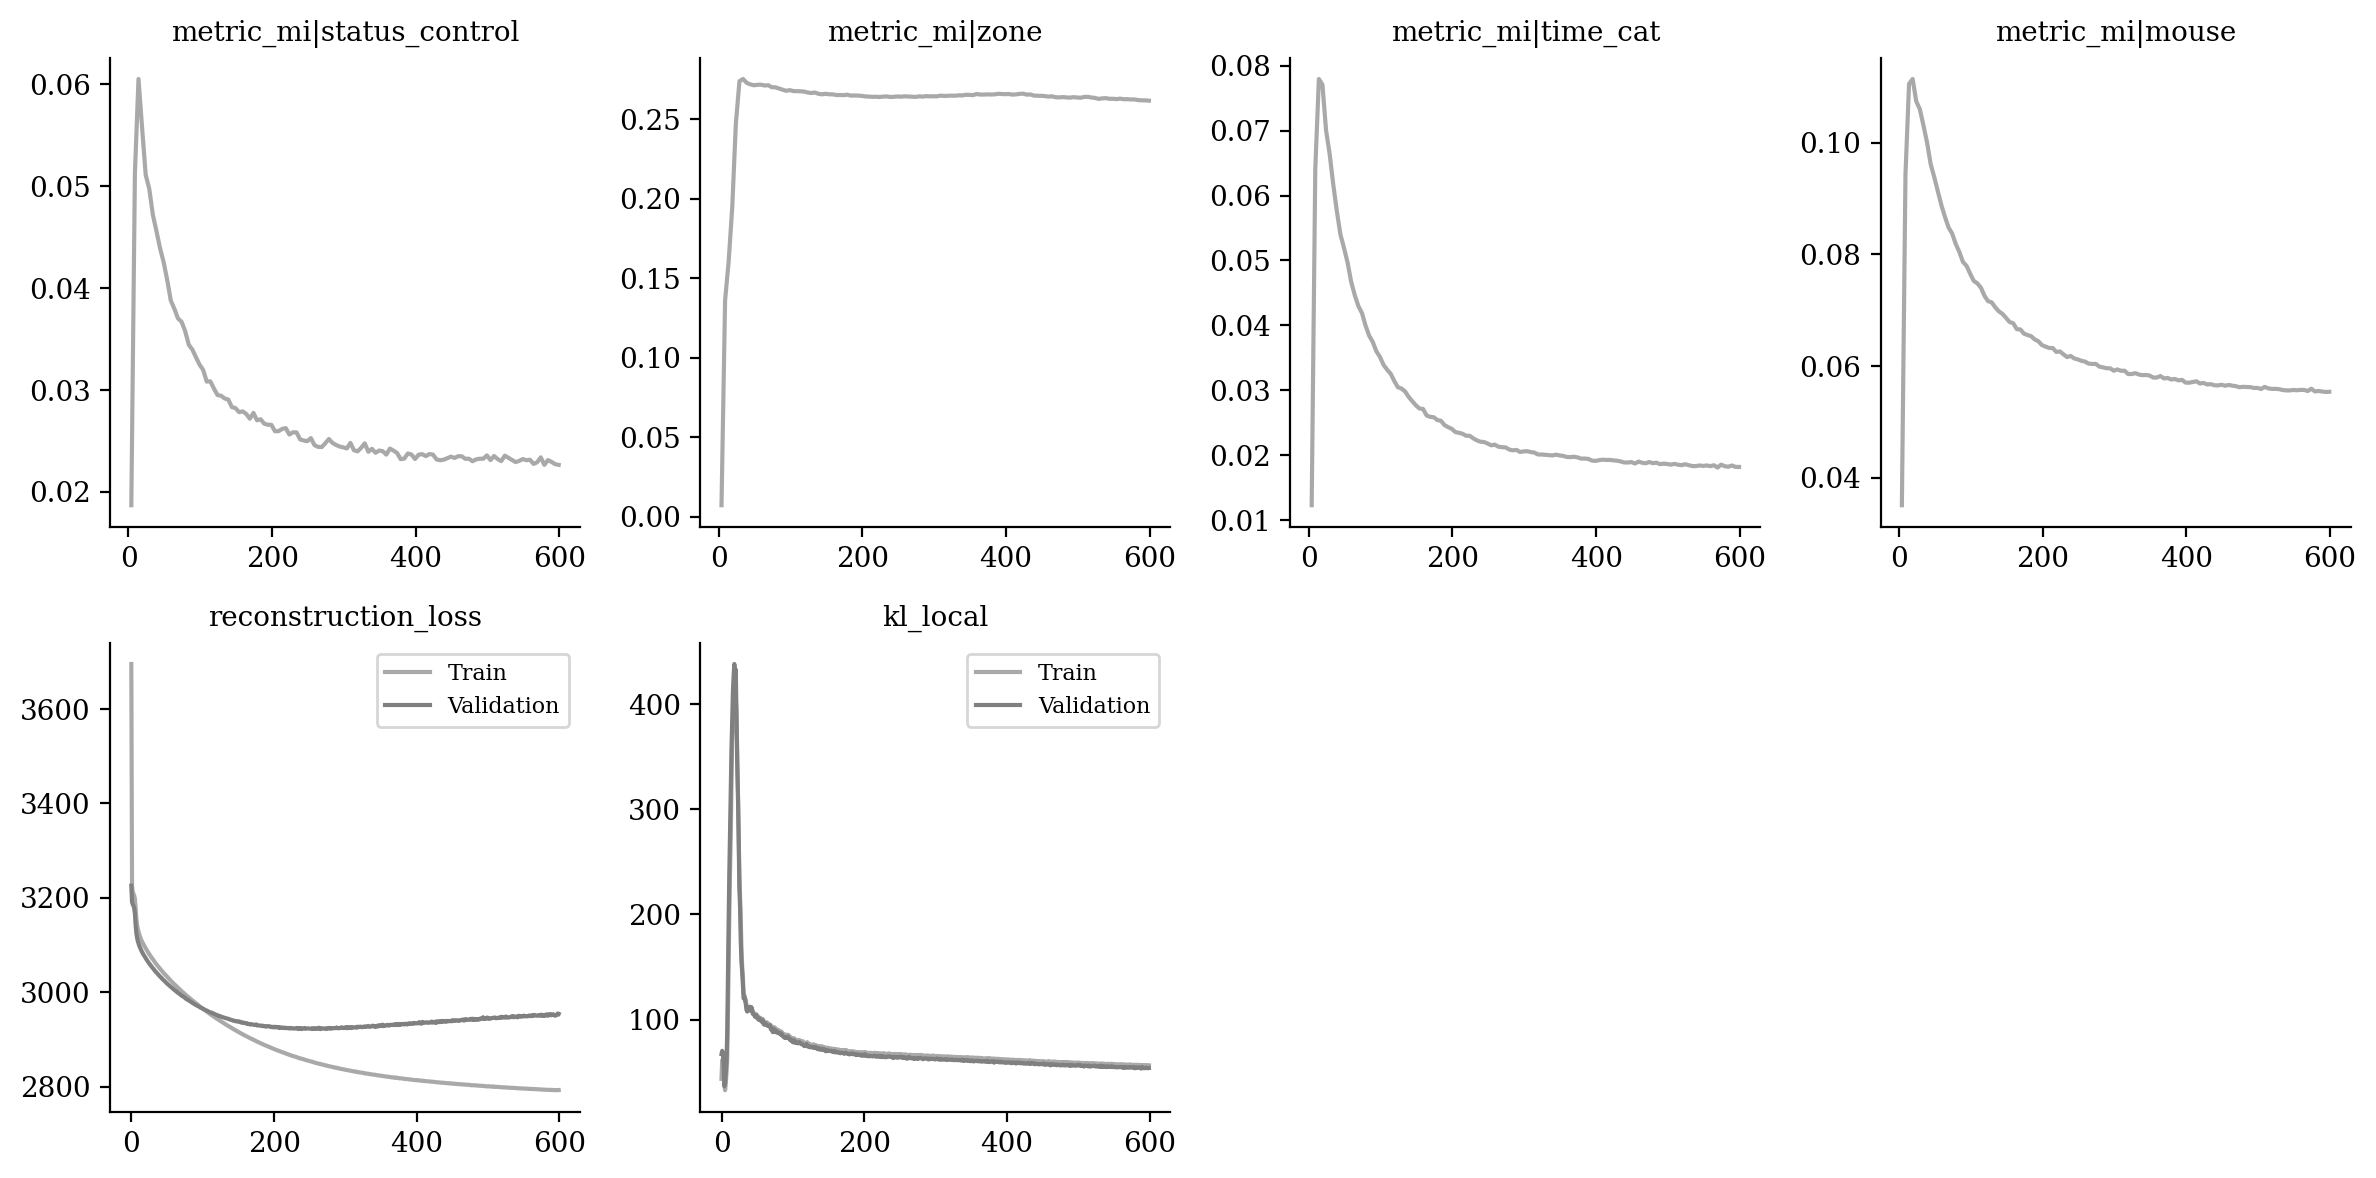

In [11]:
vae.plot_training_history(
    ignore_first=0,
    n_col=4,
    metrics_name=["metric_mi|status_control", "metric_mi|zone", "metric_mi|time_cat", "metric_mi|mouse",
                 "reconstruction_loss", "kl_local"]
)

In [12]:
from tardis._disentanglementmanager import DisentanglementManager as DM

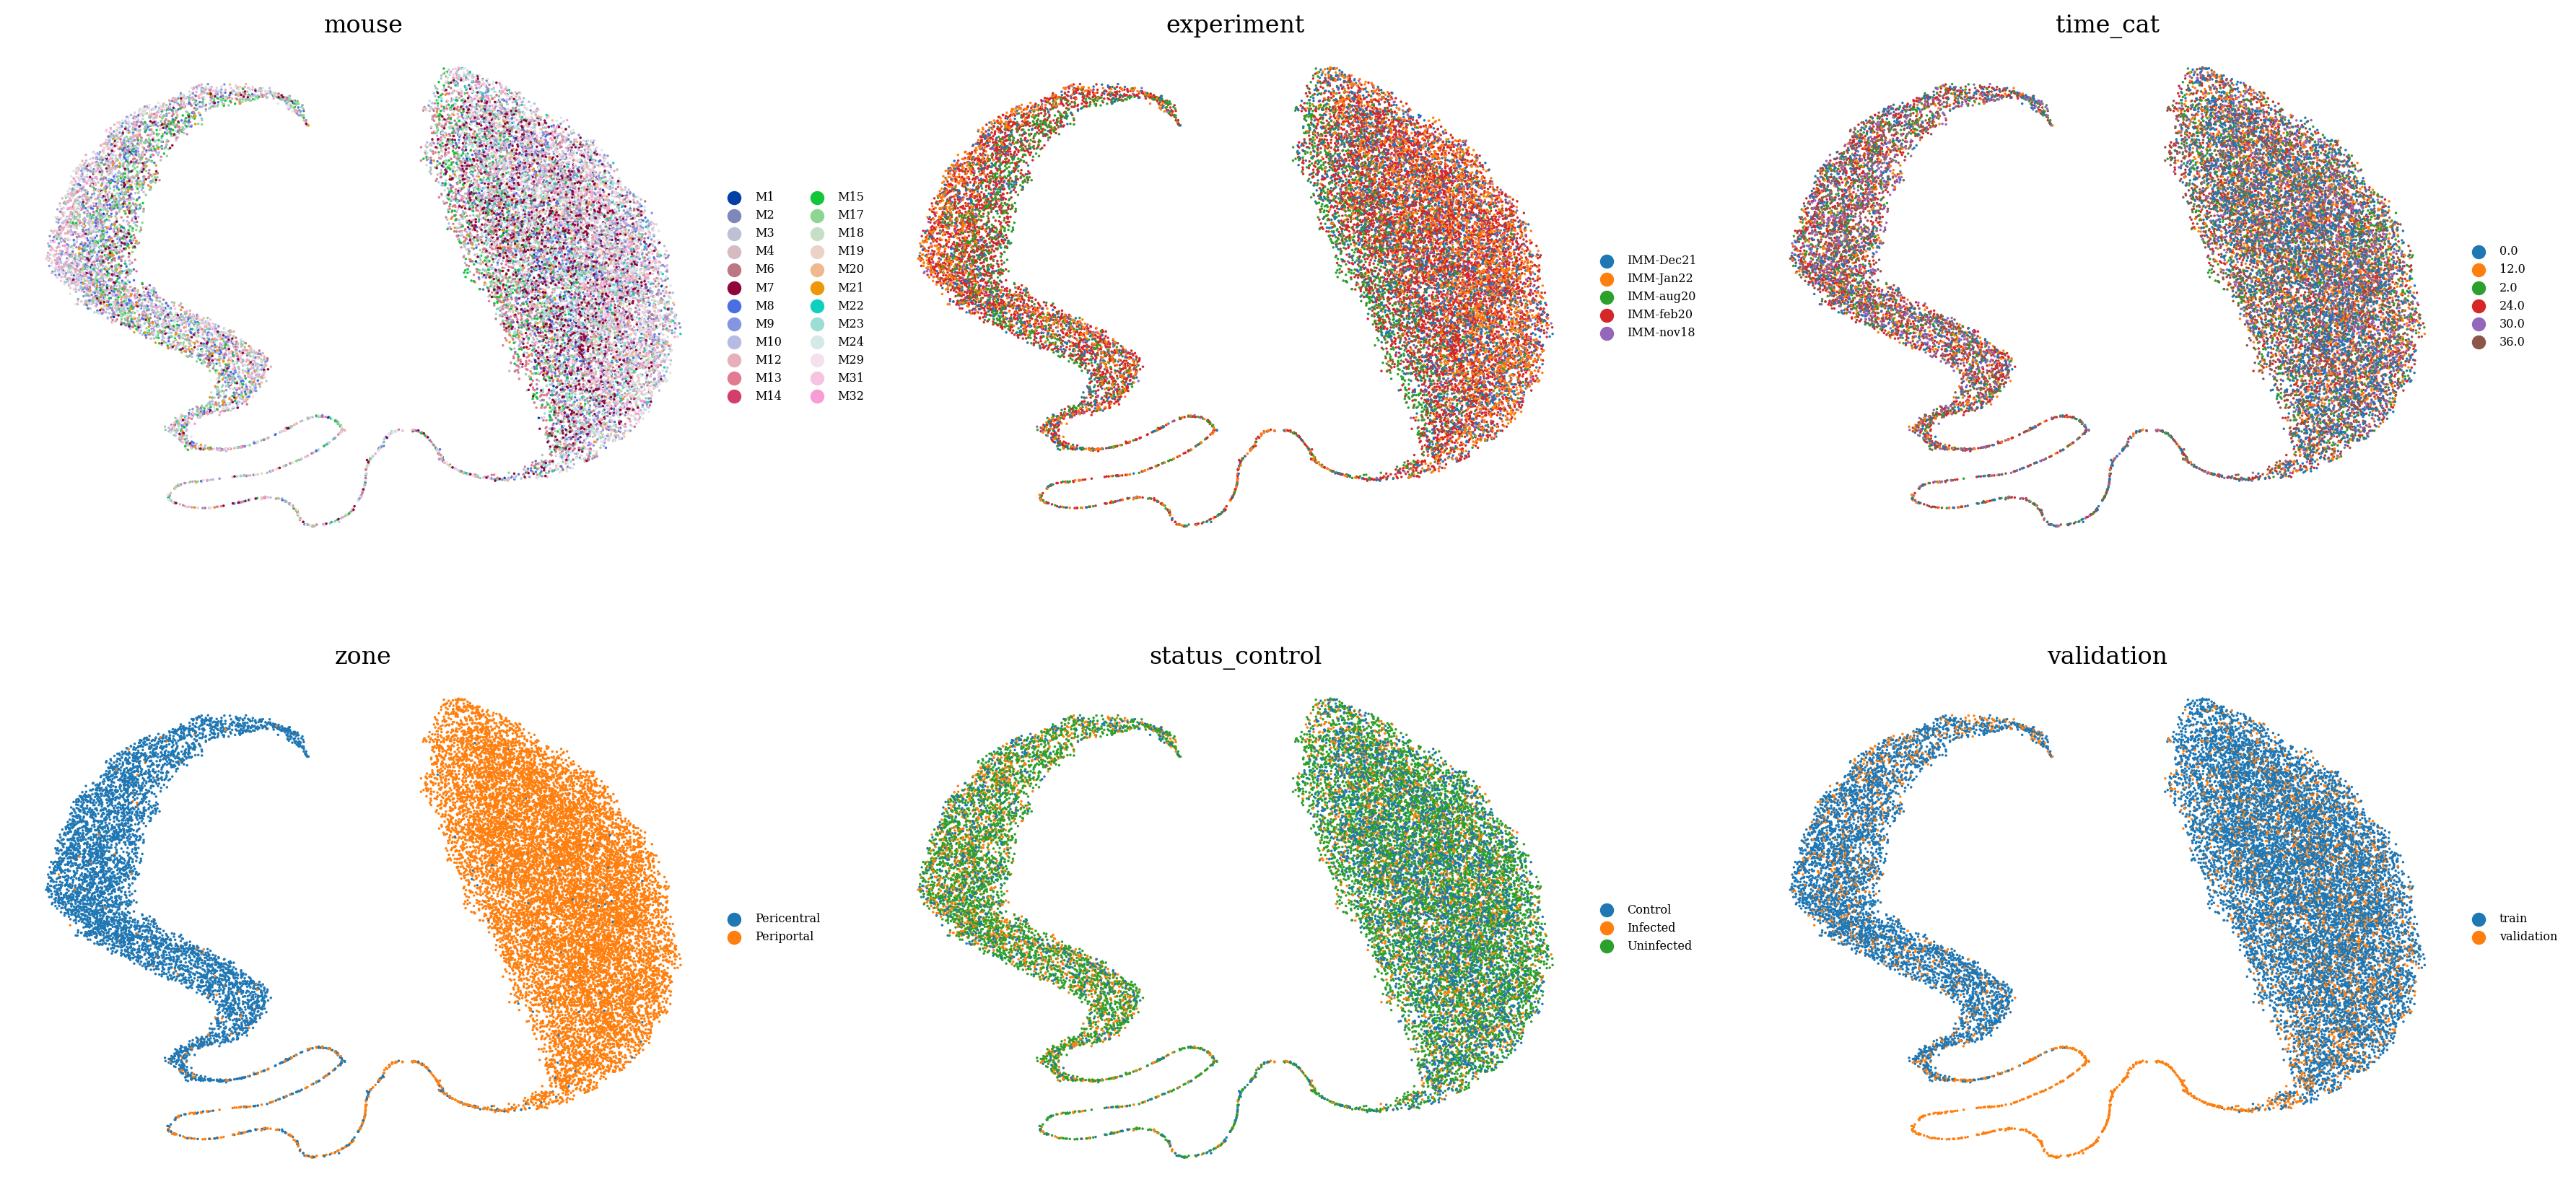

In [13]:
sublatent = DM.configurations.get_by_obs_key("zone").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

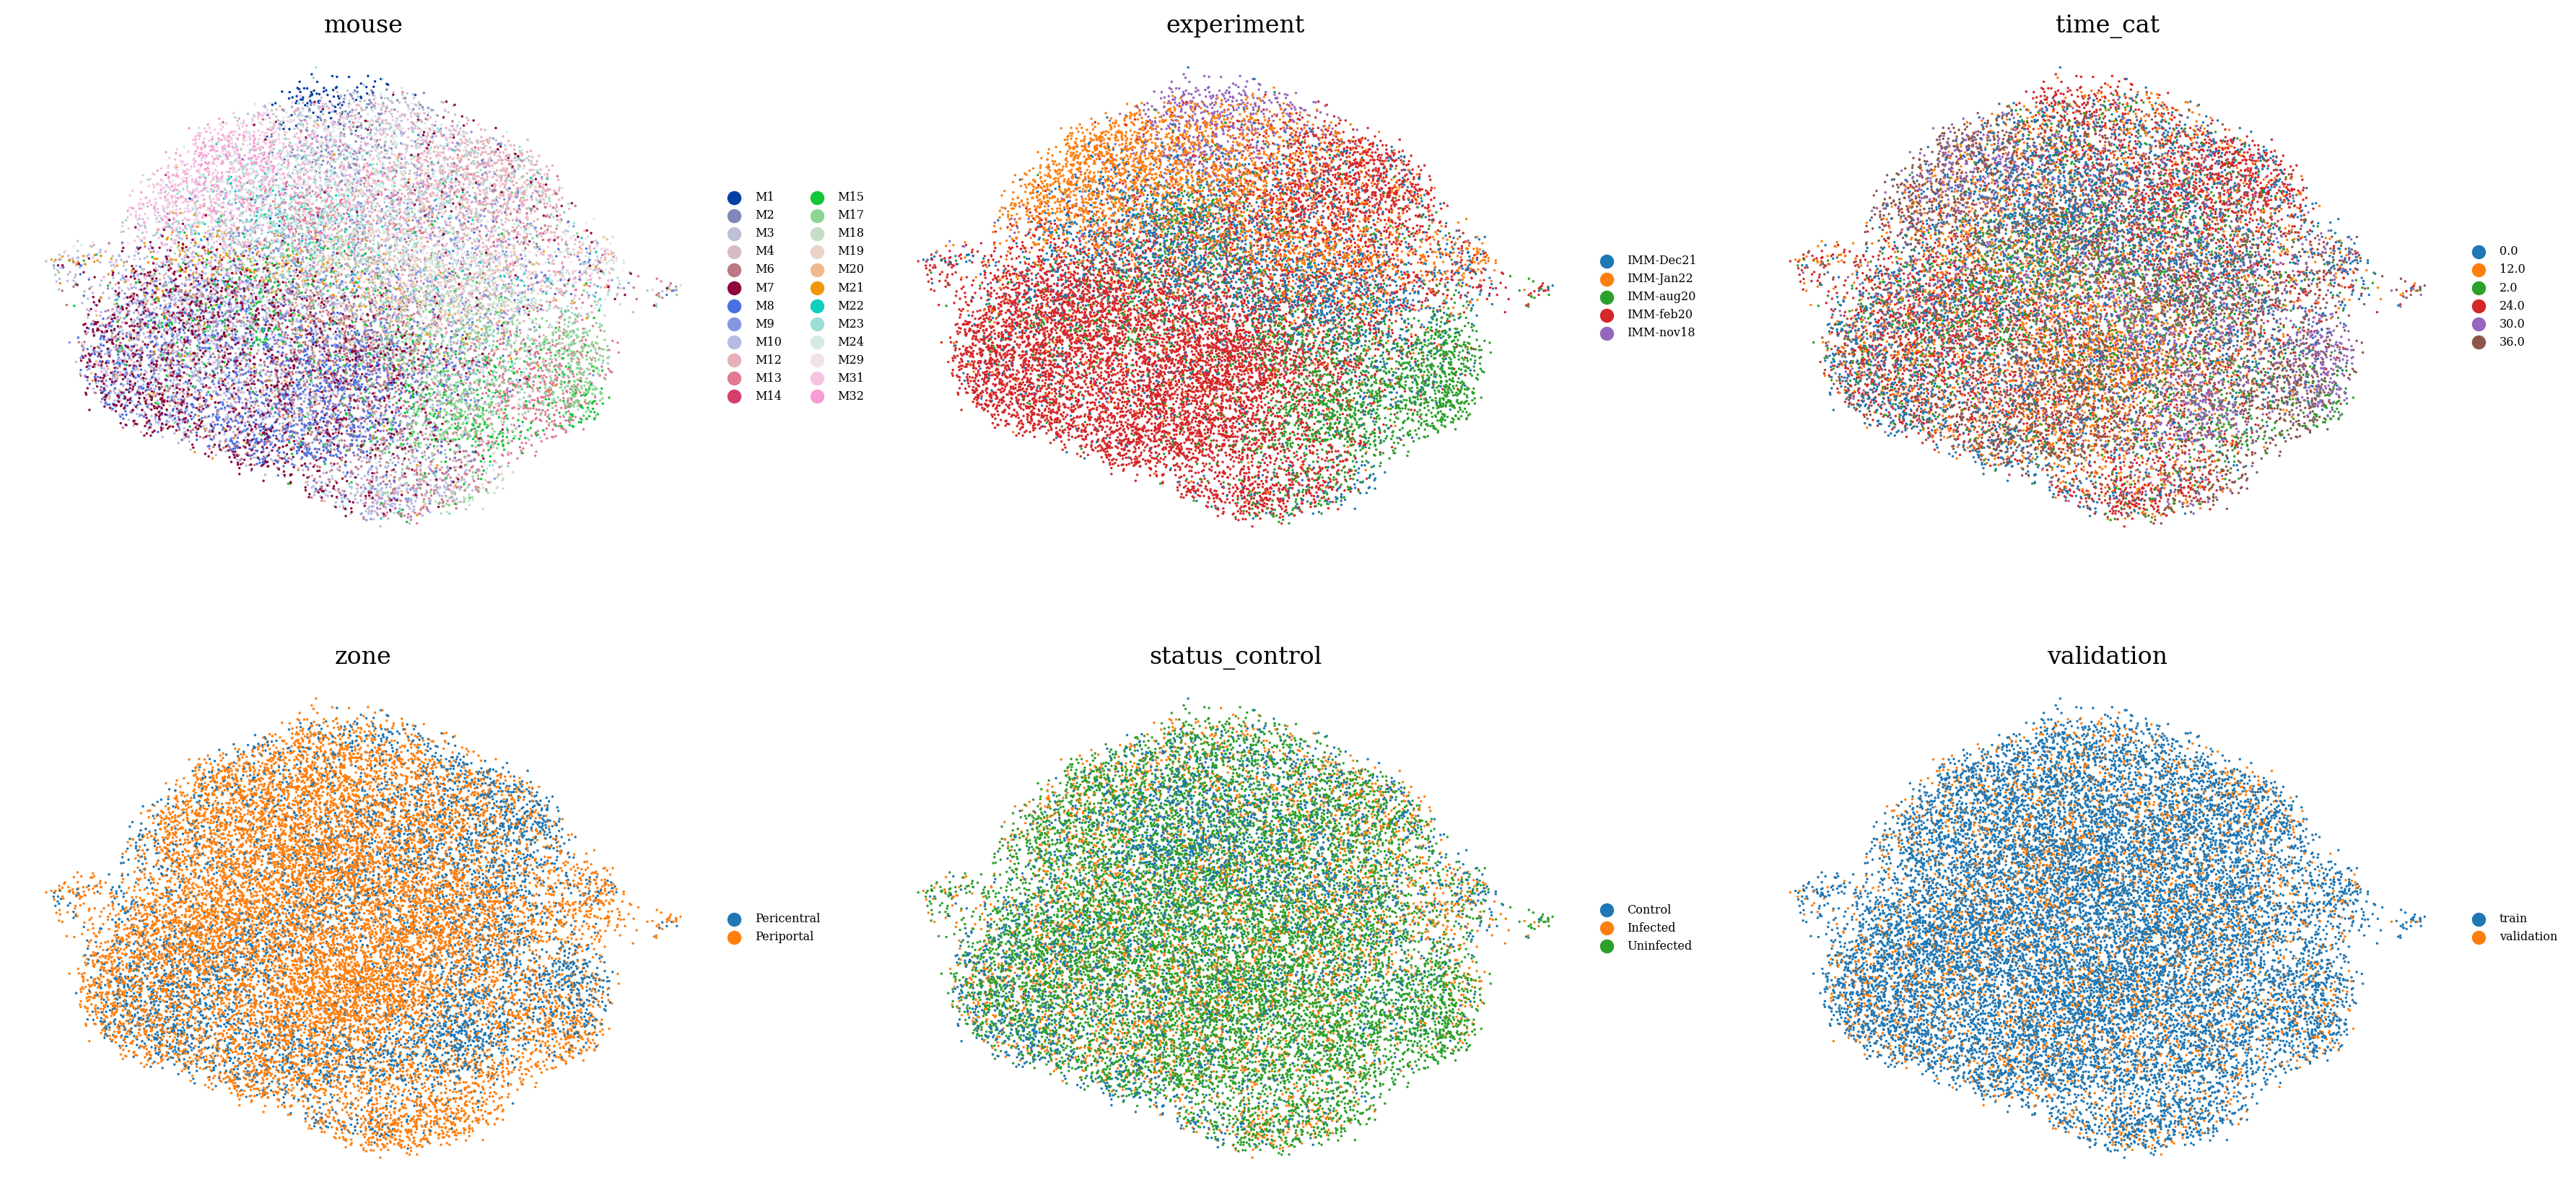

In [14]:
sublatent = DM.configurations.unreserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [15]:
from tardis._utils.functions import label_transfer

In [16]:
k = "zone"
sublatent = DM.configurations.get_by_obs_key(k).reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())

reference_embeddings = latent[vae.train_indices, :].copy()
query_embeddings = latent[vae.validation_indices, :].copy()

sc.pp.neighbors(reference_embeddings, n_neighbors=30)
label_transfer(reference_embeddings, query_embeddings, cluster_list=[k], neighbors_count=30)

predicted = query_embeddings.obs[f"transf_{k}"].astype(str).values
true = query_embeddings.obs[k].astype(str).values

import sklearn
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.8916010498687664,
 'precision_macro': 0.8678991207592108,
 'recall_macro': 0.8726242673672444,
 'f1_score_macro': 0.870201753030692,
 'precision_micro': 0.8916010498687664,
 'recall_micro': 0.8916010498687664,
 'f1_score_micro': 0.8916010498687664,
 'precision_weighted': 0.892379694057648,
 'recall_weighted': 0.8916010498687664,
 'f1_score_weighted': 0.8919468691453998,
 'confusion_matrix': array([[ 925,  194],
        [ 219, 2472]])}

In [22]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(true.reshape(-1, 1), true)
dummy_predictions = dummy_clf.predict(true.reshape(-1, 1))
accuracy = sklearn.metrics.accuracy_score(true, dummy_predictions)
print(f"Baseline Accuracy: {accuracy}")

Baseline Accuracy: 0.7062992125984252


In [23]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(true.reshape(-1, 1), true)
dummy_predictions = dummy_clf.predict(true.reshape(-1, 1))
accuracy = sklearn.metrics.accuracy_score(true, dummy_predictions)
print(f"Baseline Accuracy: {accuracy}")

Baseline Accuracy: 0.5955380577427821


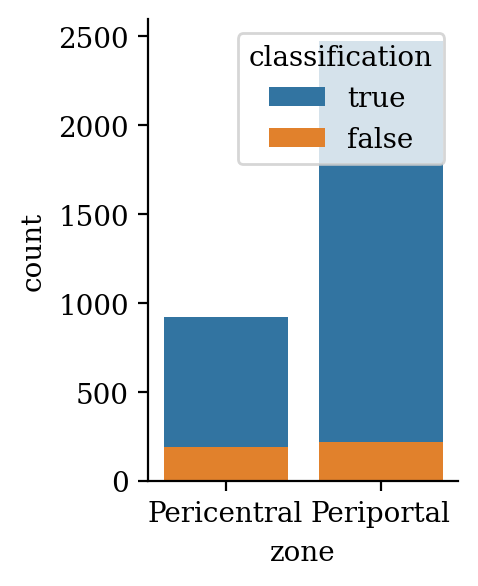

In [62]:
query_embeddings.obs["classification"] = 'false'
query_embeddings.obs.loc[query_embeddings.obs[k] == query_embeddings.obs[f"transf_{k}"], "classification"] = 'true'
grouped = query_embeddings.obs.groupby('zone')['classification'].value_counts().rename('count').reset_index()

# Plotting the data
plt.figure(figsize=(2, 3))
# Create a barplot, which inherently supports stacking by using the 'hue' argument, and normalize the height by 'proportion'
sns.barplot(data=grouped, x='zone', y='count', hue='classification', dodge=False)
sns.despine()
plt.show()